# Classes

In this notebook we will research the influence of the amount of imbalanced classes of the classifier problem on active learning.

In [20]:
## Imports ##

import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# skactiveml
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import RandomSampling
from skactiveml.utils import MISSING_LABEL

# accuracy
from balanced_accuracy import balanced_accuracy

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

In [21]:
# Generate the data
def get_data(n_samples=100, n_classes=2, weights=None, random_state=None):
    """ Creates 2 data sets, one for training, one for testing

    Returns 4-tuple:
    - Xf (array like) List of the samples for training.
    - Xt (array like) List of the samples for testing. 
    - yf (array like) List of the labels for training. 
    - yt (array like) List of the labels for testing.
    """

    X, y = make_classification(
        n_samples=n_samples,
        n_classes=n_classes,
        weights=weights,
        random_state=random_state,
        n_features=n_classes*10,
        n_informative=n_classes*5
        )
    return train_test_split(X, y, random_state=random_state)


In [22]:
# perform the active learning cycle
def get_accuracy(n_samples=100, n_classes=2, weights=None, cycles=5, al=True, nn=False):
    dat = []
    for rand in range(1):
        Xf, Xt, yf, yt = get_data(n_samples=n_samples, n_classes=n_classes, weights=weights, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        clf = SklearnClassifier(MLPClassifier(), classes=np.unique(yf)) if nn else SklearnClassifier(LogisticRegression(), classes=np.unique(yf))
        qs = UncertaintySampling(random_state=1) if al else RandomSampling(random_state=1)

        out = []

        clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y, clf) if al else qs.query(Xf, y)
            y[i] = yf[i]
            clf.fit(Xf, y)

            # predict the labels
            y_predict = clf.predict(Xt)
            # get the balanced accuracy
            out.append(balanced_accuracy(yt, y_predict))
        dat.append(out)

    return np.mean(np.array(dat), axis=0)


In [23]:
def class_weights(n_classes):
    # Generate the first element in the list
    first_element = 1
    
    # Initialize the list with the first element
    percentages = [first_element]
    
    # Generate the subsequent elements, each roughly half the size of the previous one
    for _ in range(n_classes - 1):
        next_element = percentages[-1] * 0.5
        percentages.append(next_element)
    
    # Normalize to ensure the sum is equal to 1
    total_sum = sum(percentages)
    percentages = [element / total_sum for element in percentages]
    return percentages

In [24]:
# Plot function
def plot_accuracy(title, data, ax):
    for (acc, name) in data:
        x = np.arange(len(acc))
        ax.plot(x, acc, label=name)
    ax.legend()
    ax.set_ylabel('Balanced accuracy')
    ax.set_xlabel('Samples asked at oracle')
    ax.set_title(title)

In [25]:
# perform random sampling for different class sizes
dataR = []
for n_classes in range(2,4):
    dataR.append(
        (get_accuracy(n_classes=n_classes, weights=class_weights(n_classes=n_classes), al=False),
         f'{n_classes} classes')
        )

In [26]:
# perform uncertainty sampling for different class sizes
dataU = []
for n_classes in range(2,4):
    dataU.append(
        (get_accuracy(n_classes=n_classes, weights=class_weights(n_classes=n_classes), al=True),
         f'{n_classes} classes')
        )

In [27]:
# perform uncertainty sampling for different class sizes with a neural network
dataN = []
for n_classes in range(2,4):
    dataN.append(
        (get_accuracy(n_classes=n_classes, weights=class_weights(n_classes=n_classes), al=True, nn=True),
         f'{n_classes} classes')
        )

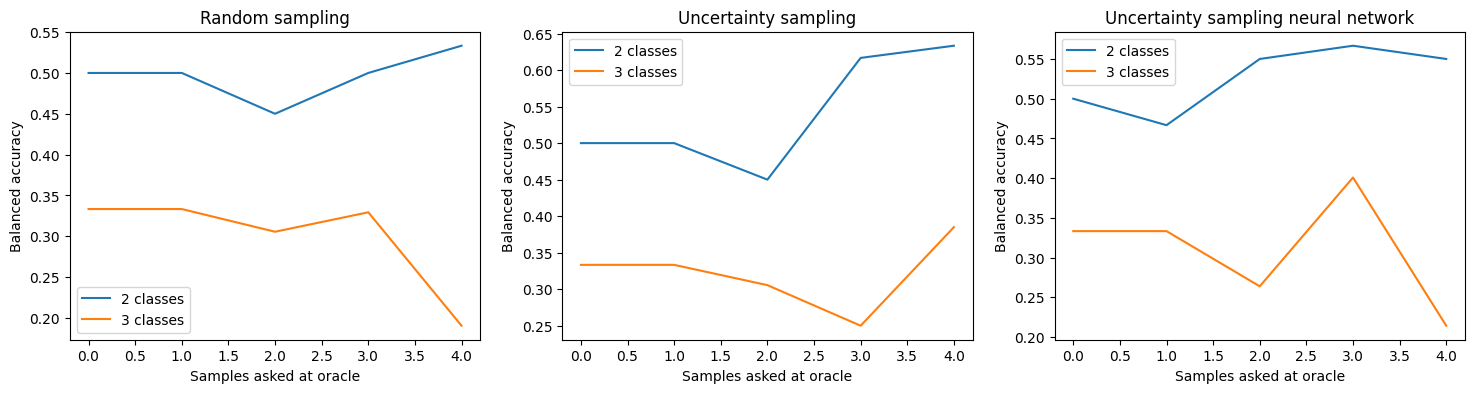

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

plot_accuracy('Random sampling', dataR, axs[0])
plot_accuracy('Uncertainty sampling', dataU, axs[1])
plot_accuracy('Uncertainty sampling neural network', dataN, axs[2])